# 1.Setting

## 1)Important required libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.models as models
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

## 2) Hyperparameter

In [2]:
batch_size = 16 #16
learning_rate = 0.001
epoch = 20 #20

n_node = 1024 # customized last layer 의 노드 수. 64, 128, 256, 512, 1024
dropratio = 0.5 #얼마나 드랍시킬 지 inverse keepratio

imgsize = 256

# 2. Data Loader
## 트레이닝 데이터

In [3]:
img_dir = "warning_climbing/train"

train_data = dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(imgsize*2),
    transforms.RandomCrop(imgsize),
    transforms.RandomHorizontalFlip(),
    
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))
print(train_data.__len__())
train_batch = data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers=2)



196


## 고정된 데이터 셋

In [4]:
img_dir = "warning_climbing/val"
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
    
    transforms.CenterCrop(size=imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))


dev_batch = data.DataLoader(dev_data, batch_size = batch_size, shuffle = True, num_workers=2)



In [5]:
img_dir = "warning_climbing/test"
test_data = dset.ImageFolder(img_dir, transforms.Compose([
    
    transforms.CenterCrop(size=imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))


test_batch = data.DataLoader(test_data, batch_size = batch_size, shuffle = True, num_workers=2)



In [6]:
nclass = len(train_data.classes)

print("#of classes : %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d" %(train_data.__len__(), dev_data.__len__(), test_data.__len__()))


#of classes : 3
['bear', 'dear', 'wild_boar']
{'dear': 1, 'wild_boar': 2, 'bear': 0}
196
Training: 196, Dev: 48, Test: 48


In [7]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['bear', 'dear', 'wild_boar']
['bear', 'dear', 'wild_boar']
['bear', 'dear', 'wild_boar']


# 3. Model
## 1) Pretrained VGG Model

In [8]:
vgg = models.vgg19(pretrained = True)

for name, module in vgg.named_children():
    print(name)
    
print(list(vgg.children())[0])
print(list(vgg.children())[-1])


print(list(vgg.children())[0][0]) #필요시

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

## 2) Customized Fully Model

In [9]:
base_dim = 64
fsize = imgsize / 32

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        self.layer0 = nn.Sequential(*list(vgg.children())[0])
        
        
        
        self.layer1 = nn.Sequential(
            #nn.Linear(8 * base_dim * int(fsize) * int(fsize) , n_node),
            nn.Linear(1 * 512 * 8 * 8 , n_node),

            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio), #0.3만큼 드랍하자
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout(dropratio),
            
            nn.Linear(n_node, nclass),
            
        )
        
        #weight initalization
        for m in self.layer1.modules() :
            #print(m)
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
                
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)    
                
    def forward(self, x):
        # layer 0의 사이즈를 무식하게 프린트하여 알아낼 수 있음(batchsize, x,x,x)
        # print(x.size())
        out = self.layer0(x)
#         print("size : ")
#         print(out.size())
        out = out.view(out.size(0),-1)
        out = self.layer1(out)
        return out
            
    
            

## 3) Model on GPU

In [10]:
model = MyVGG().cuda()


for params in model.layer0.parameters():
    params.required_grad = False


for params in model.layer1.parameters():
    params.required_grad = True


/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [11]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# 4. Optimizer & Loss

In [12]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(), lr = learning_rate)

# 5. Train

In [13]:
import utils
total_time = 0
disp_step = 10

to_train = True

if (to_train == False):
    netname = './nets/warning_climbing+vgg_10.pkl'
    model = torch.load(netname)
    
else :
    print("3 layer, n_node : %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval() #evaluation(test) mode로 바꾸기 -> dropout, batch normalization
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(train_batch, model)
    test_corr = utils.ComputeCorr(train_batch, model)
    
    print("Correct of train: %.2f, dev: %.2f, test: %.2f" %(train_corr, dev_corr, test_corr))
    model.train()
    
    
    netname = './nets/warning_climbing_vgg19' ########################주소
    
    #graph 그리기
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
    # 학습을 재시작 한다면
    # netname = '../nets/media_pre_vgg19.pkl'
    # model = torch.load(netname)
    
    # 파라미터 학습 여부 설정
    # for params in model.layer0.parameters():
#      params.required_grad = False


#    for params in model.layer1.parameters():
#      params.required_grad = True
#    for i in range(34,epoch):


    # 재시작하지 않는다면
    for i in range(epoch):
        start_time = time.time()
        print("%d.."%i),
        for img,label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()
            
            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()
            
            
        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        
        if (i%disp_step ==0) or (i == epoch -1):
            torch.save(model, netname+'_%d.pkl'%i, )
            print("\n[%d/%d] loss: %.3f," %(i, epoch, (loss.cpu()).data.numpy())),
            
            #evaluation(test) mode로 바꾸기 -> dropout, batch normalization에 영향을 줌
            model.eval()
            
            #train, dev, train accr
            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(dev_batch, model)
            
            print("Correct of train: %.2f, dev: %.2f, test: %.2f" %(train_corr, dev_corr, test_corr))
            model.train()
            print("time: %.2f sec..." %(total_time))
            
            # graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
            
        print("Total time: %.2f sec" %total_time)
            
    

3 layer, n_node : 1024, dropratio: 0.50
Correct of train: 33.16, dev: 35.20, test: 33.67
0..

/usr/local/anaconda2/lib/python2.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


 
[0/20] loss: 0.607, Correct of train: 57.65, dev: 54.17, test: 54.17
time: 1.80 sec...
Total time: 1.80 sec
1.. Total time: 3.58 sec
2.. Total time: 5.35 sec
3.. Total time: 7.16 sec
4.. Total time: 8.95 sec
5.. Total time: 10.78 sec
6.. Total time: 12.58 sec
7.. Total time: 14.36 sec
8.. Total time: 16.14 sec
9.. Total time: 17.93 sec
10.. 
[10/20] loss: 2.317, Correct of train: 84.69, dev: 85.42, test: 85.42
time: 19.74 sec...
Total time: 19.74 sec
11.. Total time: 21.55 sec
12.. Total time: 23.35 sec
13.. Total time: 25.17 sec
14.. Total time: 26.97 sec
15.. Total time: 28.79 sec
16.. Total time: 30.60 sec
17.. Total time: 32.38 sec
18.. Total time: 34.19 sec
19.. 
[19/20] loss: 1.615, Correct of train: 89.29, dev: 85.42, test: 85.42
time: 36.01 sec...
Total time: 36.01 sec


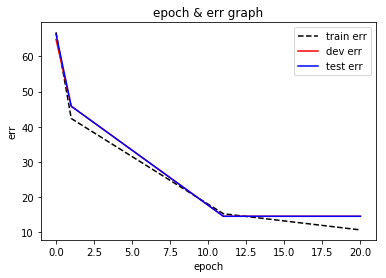

In [14]:
# epoch - err curve
if (to_train):
    plt.plot(x_epoch, y_train_err, color = 'black', label = 'train err', linestyle = '--')
    plt.plot(x_epoch, y_dev_err, color = 'red', label = 'dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label = 'test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc="upper right")
    plt.show()
    

# 6. Evaluation for dev & test data

Normalized confusion matrix


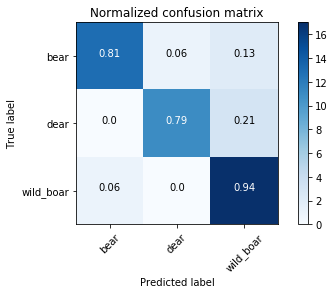

Confusion matrix, without normalization


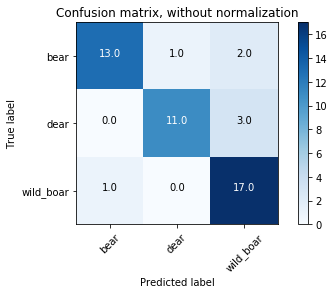

	 acc  |	 pre  |	 rec  |	 f1
 bear: 0.92 |	 0.93 |	 0.81 |	 0.87
 dear: 0.85 |	 0.92 |	 0.79 |	 0.85
 wild_boar: 0.88 |	 0.77 |	 0.94 |	 0.85
*accuracy: 0.88, precision: 0.87, recall: 0.85, *f1 score: 0.85
[AP] bear: 0.94 dear: 0.96 wild_boar: 0.92 
[mAP] 0.939
[miAP] 0.938


(array([1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 0, 1, 2, 2, 2, 0, 0, 2, 0, 2, 1, 0,
        2, 1, 0, 0, 1, 2, 2, 2, 0, 2, 0, 2, 0, 1, 2, 2, 1, 2, 2, 0, 1, 0,
        1, 0, 1, 2]),
 array([0, 1, 2, 2, 0, 0, 2, 2, 1, 2, 0, 1, 2, 1, 2, 0, 0, 2, 2, 1, 1, 0,
        2, 1, 0, 0, 1, 0, 2, 2, 0, 2, 0, 2, 0, 1, 2, 1, 1, 2, 2, 0, 1, 0,
        1, 0, 1, 2]),
 array([0.64570695, 0.56436062, 0.91211516, 0.75604075, 0.84692603,
        0.77718818, 0.99904221, 0.9757781 , 0.98464084, 0.98506898,
        0.97394651, 0.99959135, 0.92527544, 0.95670599, 0.91778034,
        0.99788994, 0.99744159, 0.99985653, 0.92990482, 0.90776479,
        0.99998271, 0.91773623, 0.94703227, 0.70140231, 0.92124707,
        0.99996889, 1.        , 0.54848629, 0.93284124, 0.99563217,
        0.98905706, 0.67949575, 0.94114381, 0.91871142, 0.99949104,
        0.99996549, 0.9646855 , 0.6464842 , 0.99009073, 0.86986816,
        0.83649826, 0.99999815, 0.99905223, 0.90739781, 0.99999928,
        0.71907151, 0.9994415 , 0.99274343]))

In [15]:
model.eval()
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Category: bear
 True predicted images/total bear category: 13 / 16
Predicted probability: [0.9739465  0.00627274 0.01978076]


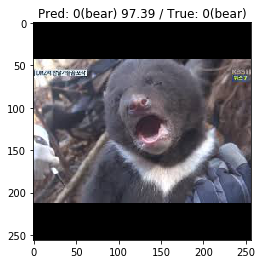

Predicted probability: [9.073978e-01 2.338686e-04 9.236833e-02]


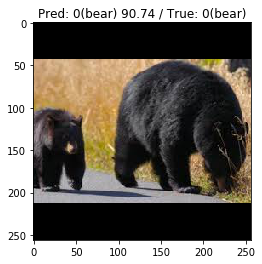

 False predicted images/total bear category: 3 / 16
Predicted probability: [0.15943351 0.64570695 0.1948595 ]


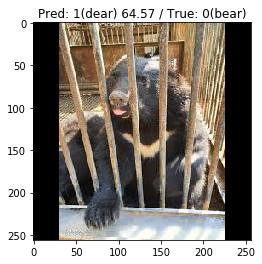

Predicted probability: [0.44732097 0.00419276 0.5484863 ]


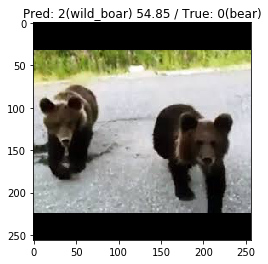

Category: dear
 True predicted images/total dear category: 11 / 14
Predicted probability: [5.82656639e-07 9.99999285e-01 1.09515064e-07]


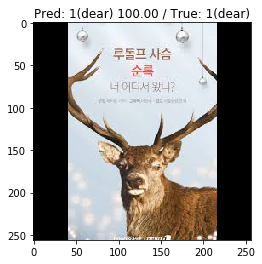

Predicted probability: [2.511730e-04 9.900907e-01 9.658076e-03]


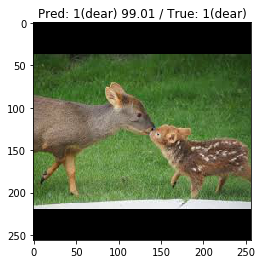

 False predicted images/total dear category: 3 / 14
Predicted probability: [0.10235069 0.25116512 0.6464842 ]


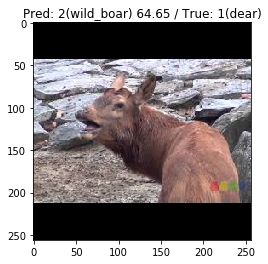

Predicted probability: [0.02157647 0.07065871 0.9077648 ]


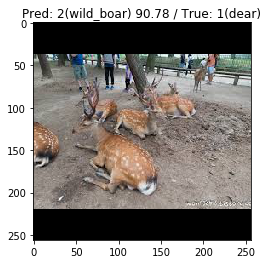

Category: wild_boar
 True predicted images/total wild_boar category: 17 / 18
Predicted probability: [0.04457744 0.02258129 0.93284124]


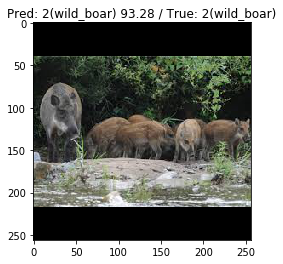

Predicted probability: [0.06814564 0.00657891 0.92527544]


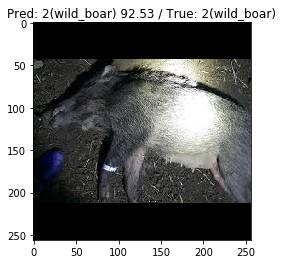

 False predicted images/total wild_boar category: 1 / 18
Predicted probability: [0.9299048  0.00358145 0.0665137 ]


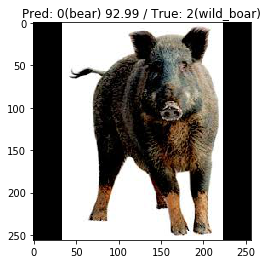

In [16]:
utils.VisTFPred(dev_batch, model,test_data.classes, batch_size, i_n=2)